In [28]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
import ml_collections as mlc
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import torch
from torch.autograd.functional import jacobian
from sklearn.cross_decomposition import CCA
from statsmodels.multivariate.cancorr import CanCorr

matplotlib.rcParams['figure.figsize'] = (25, 5)

from DGP import dgp 
from BasicAutoEncoder.model import Encoder, Decoder, AutoEncoder, train
import BasicAutoEncoder
from BasicAutoEncoder.util import plot_factor_estimates, plot_train_hist, plot_reconstructed_y, get_trainable_params
from mcmc.ErrorProcess import IIDErrorProcess, ArErrorProcess
from mcmc.mcmc import trainMCMC


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
cfg = mlc.ConfigDict()
cfg.factor_dim = 5
cfg.obs_dim = 20
cfg.p_factor = 2
cfg.covar_factor = np.eye(cfg.factor_dim)/100
cfg.p_eps = 5
cfg.covar_eps = np.eye(cfg.obs_dim)/1000
cfg.T_train = 10000
cfg.T_test = 300
cfg.T = cfg.T_train + cfg.T_test


## Nonlinear decoder DGP
Obtain the simulated $y$

Obtained stable system after 153 iterations.
Obtained stable system after 195 iterations.


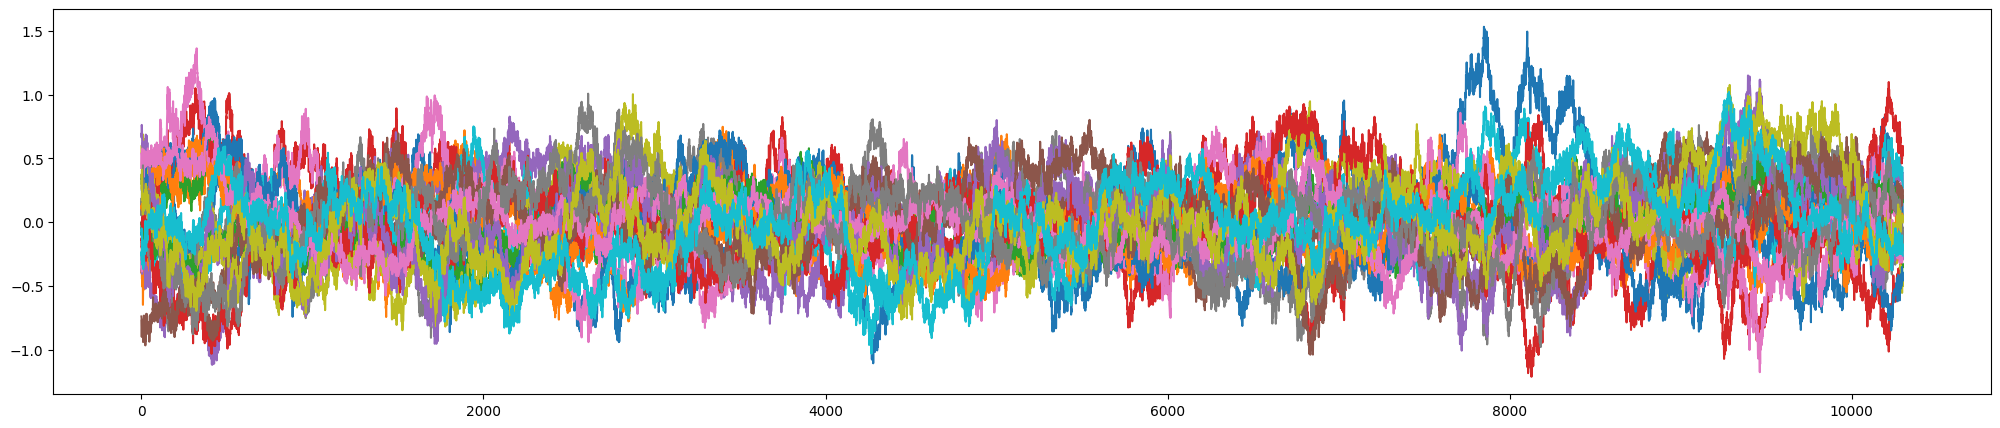

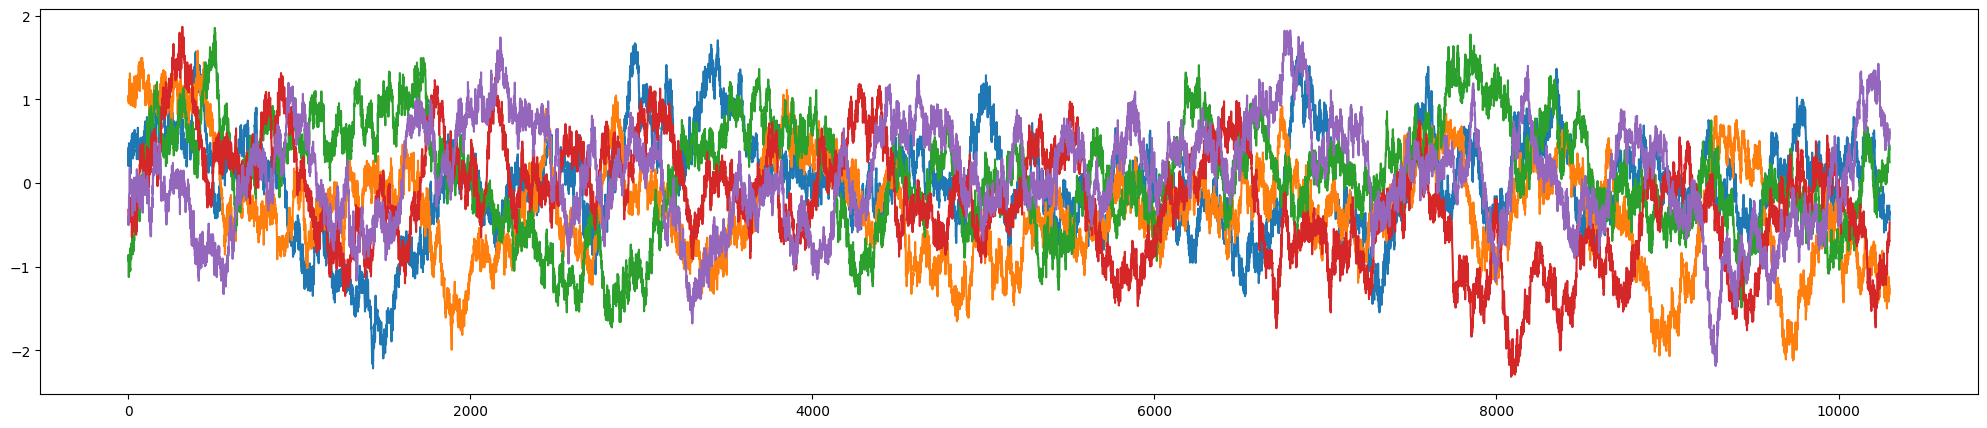

In [30]:
dec = Decoder(hidden_dim=[cfg.factor_dim, cfg.obs_dim], activation=nn.Tanh(), lastLayerLinear=False)
f, y, obs_residual = dgp.getSimulatedNonlinearVarP(factor_dim=cfg.factor_dim,p=cfg.p_factor, obs_dim=cfg.obs_dim,T=cfg.T, dec=dec, covar_factor = cfg.covar_factor, p_eps = cfg.p_eps,covar_eps=cfg.covar_eps, centered=True)
plt.plot(y);
plt.figure()
#plt.plot(obs_residual);
#plt.figure()
#plt.plot(y-obs_residual);
#plt.figure()
plt.plot(f);

f_train = f[0:cfg.T_train]
f_test = f[cfg.T_train:]

y_train = y[0:cfg.T_train]
y_test = y[cfg.T_train:]

In [31]:
#j = jacobian(dec, torch.Tensor(f[0]).float()).detach().numpy()
#cov = j @ cfg.covar_factor @ j.T
#cov.shape

## Estimate nonlinear model
TODO: this should all be hyperparameter tuned etc.

In [32]:
def cca_callback_gen(mod, f, y):
    def cca_callback(train_hist):
        if 'cca_r2' not in train_hist.keys():
            train_hist['cca_r2'] = []
        f_hat = mod.enc(torch.Tensor(y).float()).detach().numpy()
        cc = np.mean(CanCorr(f_hat, f).cancorr)
        train_hist['cca_r2'].append(cc)
    return cca_callback
        

In [33]:
dec = Decoder(hidden_dim=[cfg.factor_dim, cfg.obs_dim], activation=nn.Tanh(), lastLayerLinear=False)
enc = Encoder(hidden_dim=[cfg.obs_dim, cfg.factor_dim], activation=nn.Tanh(), lastLayerLinear=False)
mod = AutoEncoder(enc=enc, dec=dec)
print(f"Number of trainable paramaters {get_trainable_params(mod)}")
errorProcess = IIDErrorProcess(n=cfg.obs_dim, T = cfg.T)
#errorProcess = ArErrorProcess(n=cfg.obs_dim, T = cfg.T, d=5)
cback = cca_callback_gen(mod, f, y)
train_hist = trainMCMC(X=y,model=mod, errorProcess = errorProcess, n_epoch=20, lr = 0.0001, epoch_callback=cback)
print(f"Training loss: {train_hist['loss'][-1]}, Validation Loss: {train_hist['val_loss'][-1]}")

Number of trainable paramaters 225
10300 3090
(20,) (20, 20)
1 0.7839587656167437656167431


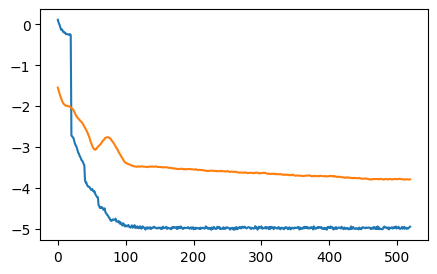

In [ ]:
plot_train_hist(train_hist, log=True)

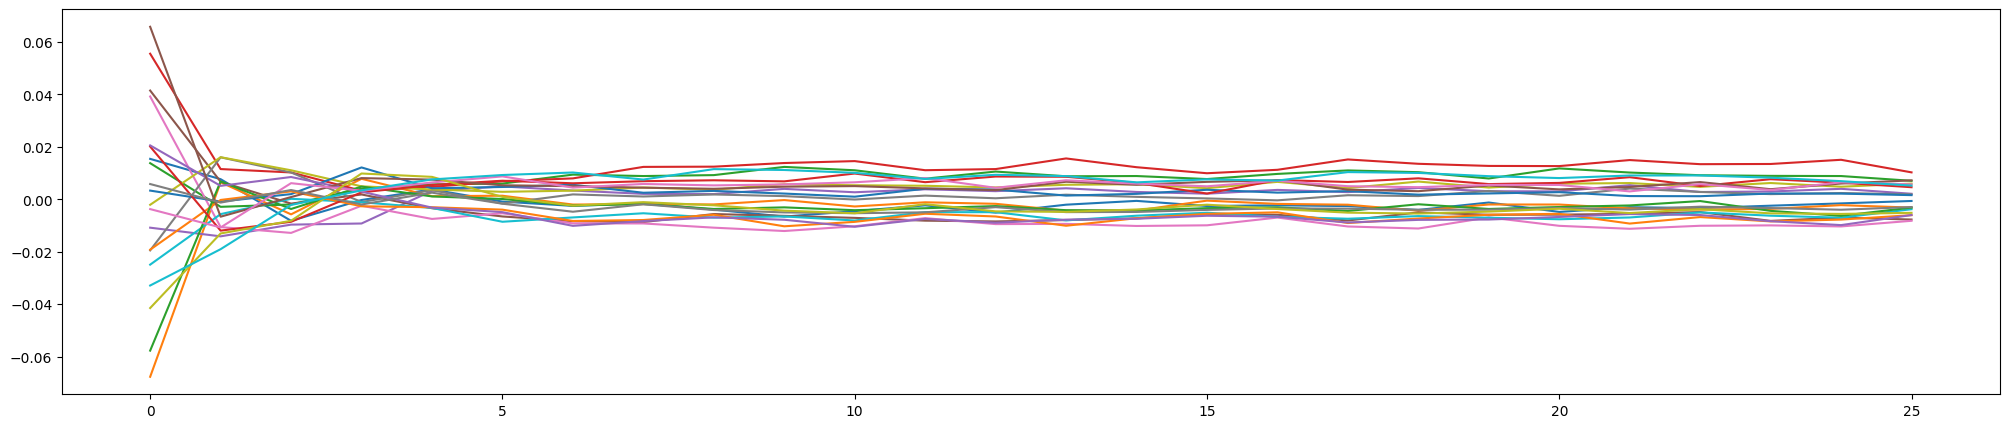

In [ ]:
plt.plot(np.stack(errorProcess.fit_hist['mu']));

In [ ]:
#plt.plot(np.stack(errorProcess.fit_hist['coeff'])[:,:,4]);

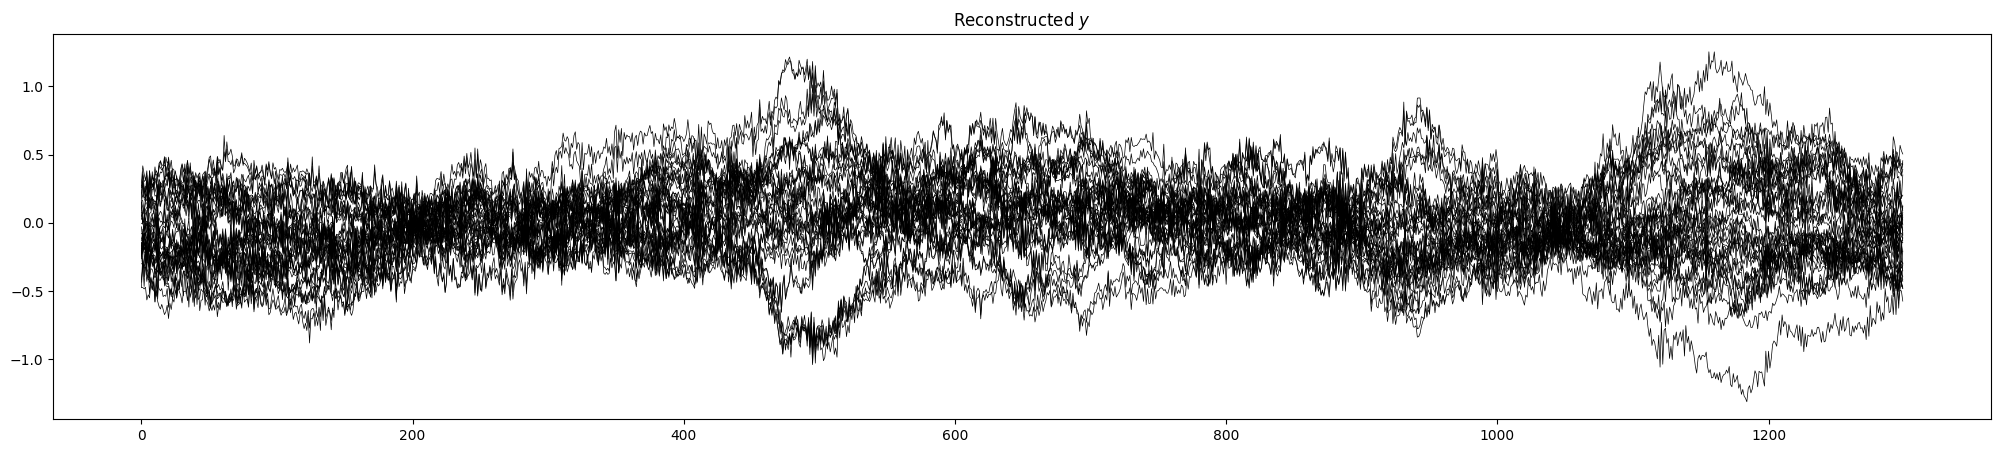

In [ ]:
plot_reconstructed_y(mod, y, c='black', linewidth=0.5)
plt.plot(y, c='black', linewidth=0.5);


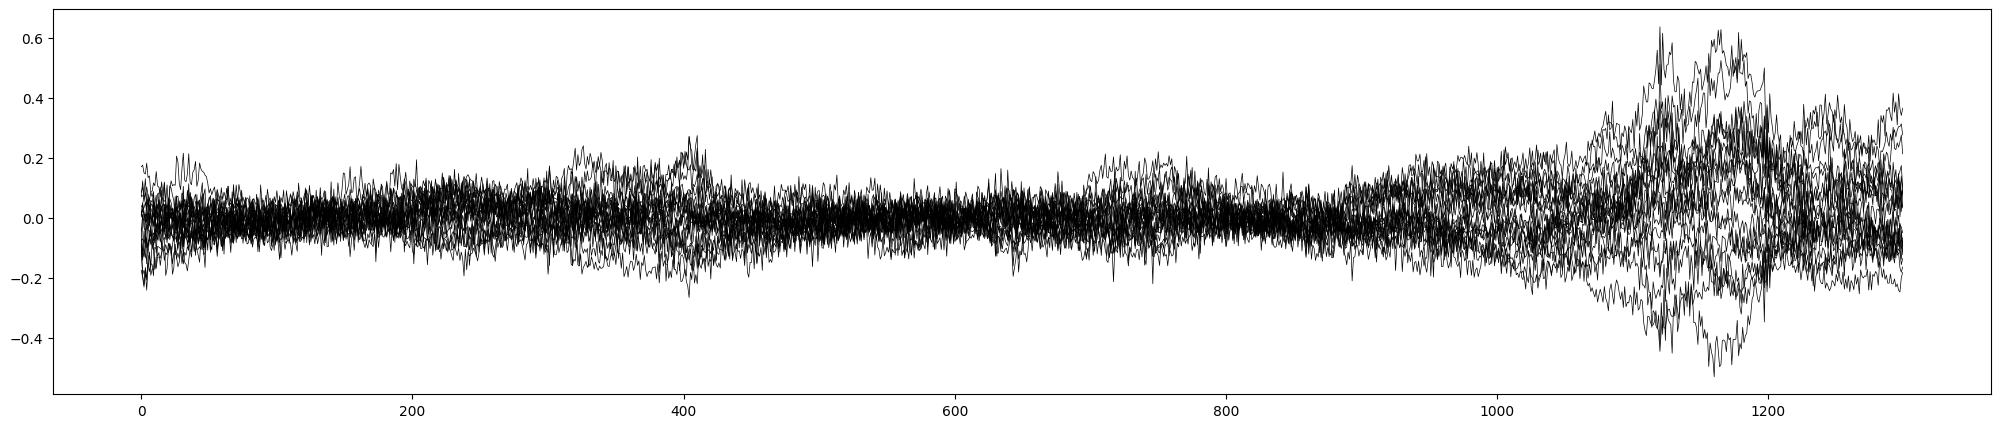

In [ ]:
y_pred = mod(torch.Tensor(y)).detach().numpy()
plt.figure()
plt.plot(y_pred-y, c='black', linewidth=0.5);

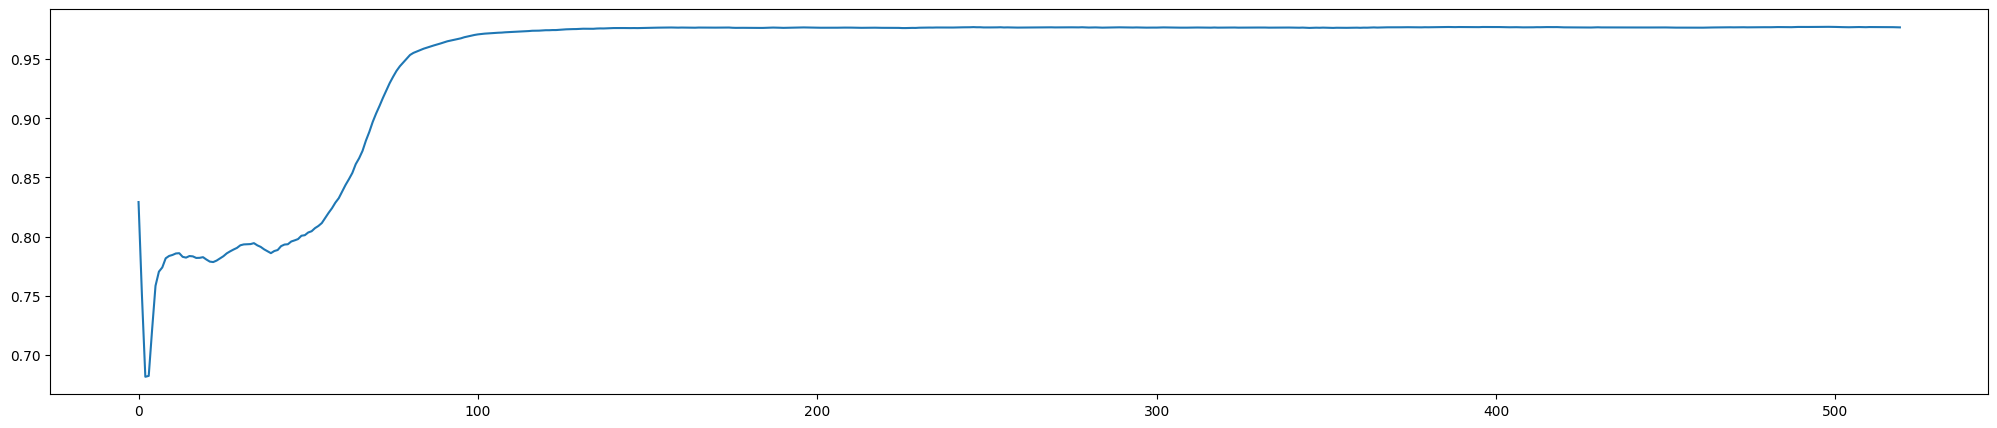

In [ ]:
plt.plot(train_hist['cca_r2'])

In [ ]:
f_test_hat = mod.enc(torch.Tensor(y_test).float()).detach().numpy()
cc = np.mean(CanCorr(f_test_hat, f_test).cancorr)
print(f"cc on test data: {cc}")

cc on test data: 0.9698853547272701


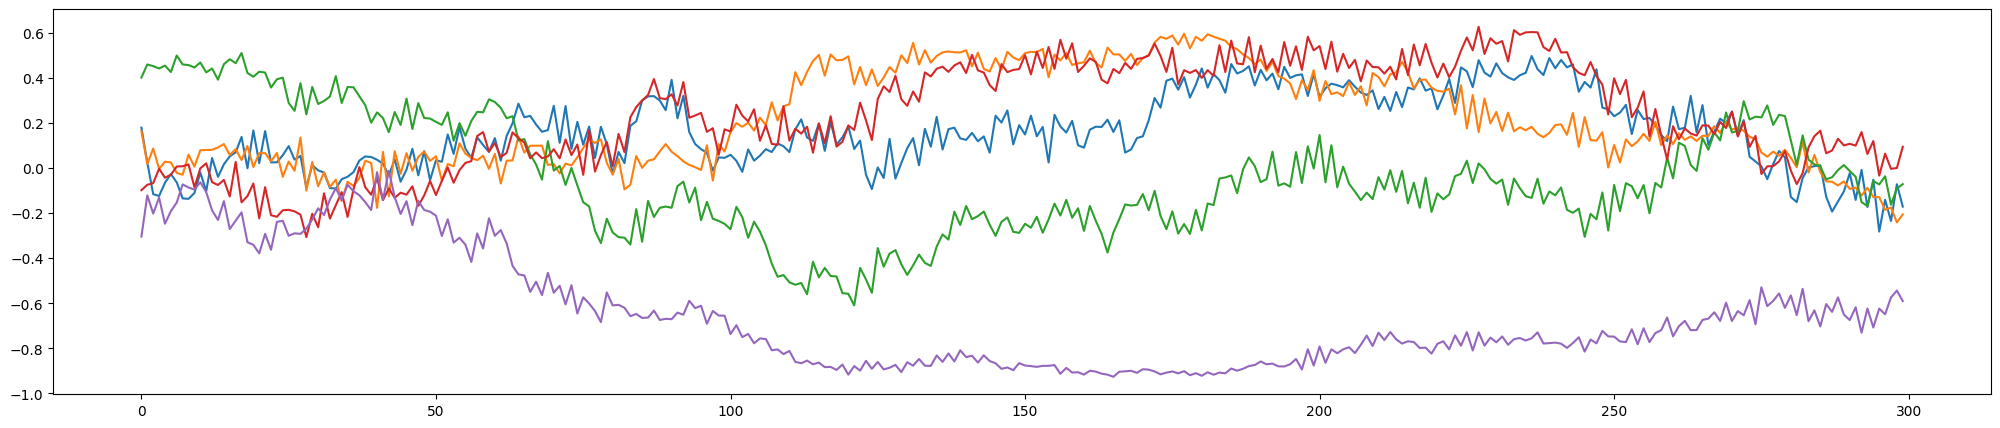

In [ ]:
plt.plot(f_test_hat);

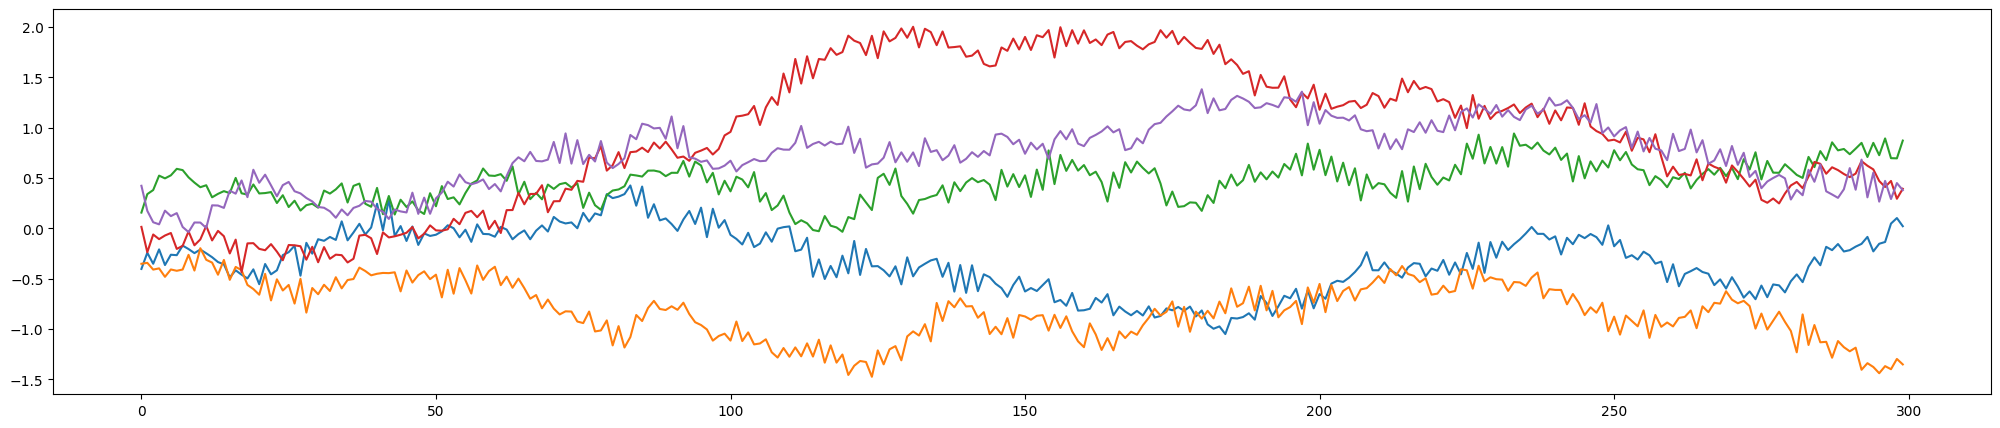

In [ ]:
plt.plot(f_test);

## Estimate linear model on nonlinear DGP

In [ ]:
dec = Decoder(hidden_dim=[cfg.factor_dim, cfg.obs_dim], activation=nn.Identity())
enc = Encoder(hidden_dim=[cfg.obs_dim, cfg.factor_dim], activation=nn.Identity())
mod = AutoEncoder(enc=enc, dec=dec)
print(f"Number of trainable paramaters {get_trainable_params(mod)}")
errorProcess = IIDErrorProcess(n=cfg.obs_dim, T = cfg.T)
#errorProcess = ArErrorProcess(n=cfg.obs_dim, T = cfg.T, d=5)
cback = cca_callback_gen(mod, f, y)
train_hist = trainMCMC(X=y,model=mod, errorProcess = errorProcess, n_epoch=20, lr = 0.0001, epoch_callback=cback)
print(f"Training loss: {train_hist['loss'][-1]}, Validation Loss: {train_hist['val_loss'][-1]}")

Number of trainable paramaters 225
1300 390
(20,) (20, 20)
1 0.7869552494046187494046187
2 0.029606641187231141187231143
3 0.020367805035354528035354528
4 0.012495077008686803008686803
5 0.010087497536081727536081727
6 0.008485194577269945577269945
7 0.007463104793918703793918703
8 0.007002786140631765140631765
9 0.0070239389290914389290914306
10 0.006659033624644876246448765
11 0.006855255615133157151331574
12 0.006949523121066805210668055
13 0.006929152024545112245451125
14 0.00682554990209421902094219
15 0.007293560802723959027239595
16 0.006839832928665884286658845
17 0.006883312212928261129282615
18 0.006753665645905474459054745
19 0.006781016220953377209533774
20 0.006786809131189078311890785
21 0.007015485419098767190987675
22 0.007155339743294502532945025
23 0.006735564445040924450409245
24 0.006937755587868335878683355
25 0.006956922846546087565460875
26 0.00700739201755602017556027
Training loss: 0.00700739201755602, Validation Loss: 0.010840309583223783


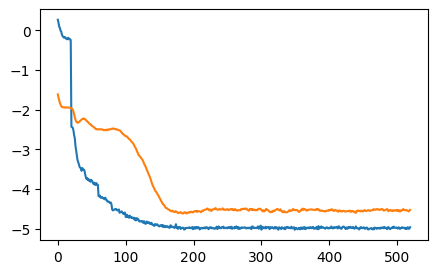

In [ ]:
plot_train_hist(train_hist, log=True)

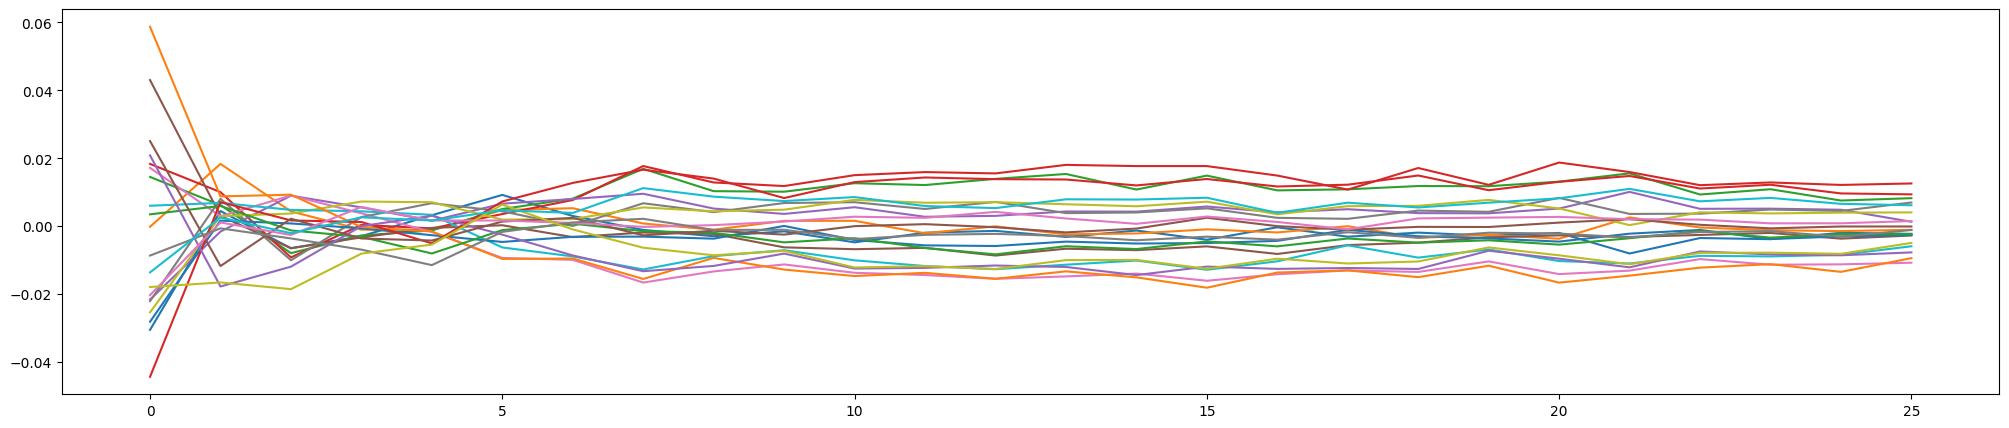

In [ ]:
plt.plot(np.stack(errorProcess.fit_hist['mu']));

In [ ]:
#plt.plot(np.stack(errorProcess.fit_hist['coeff'])[:,:,4]);

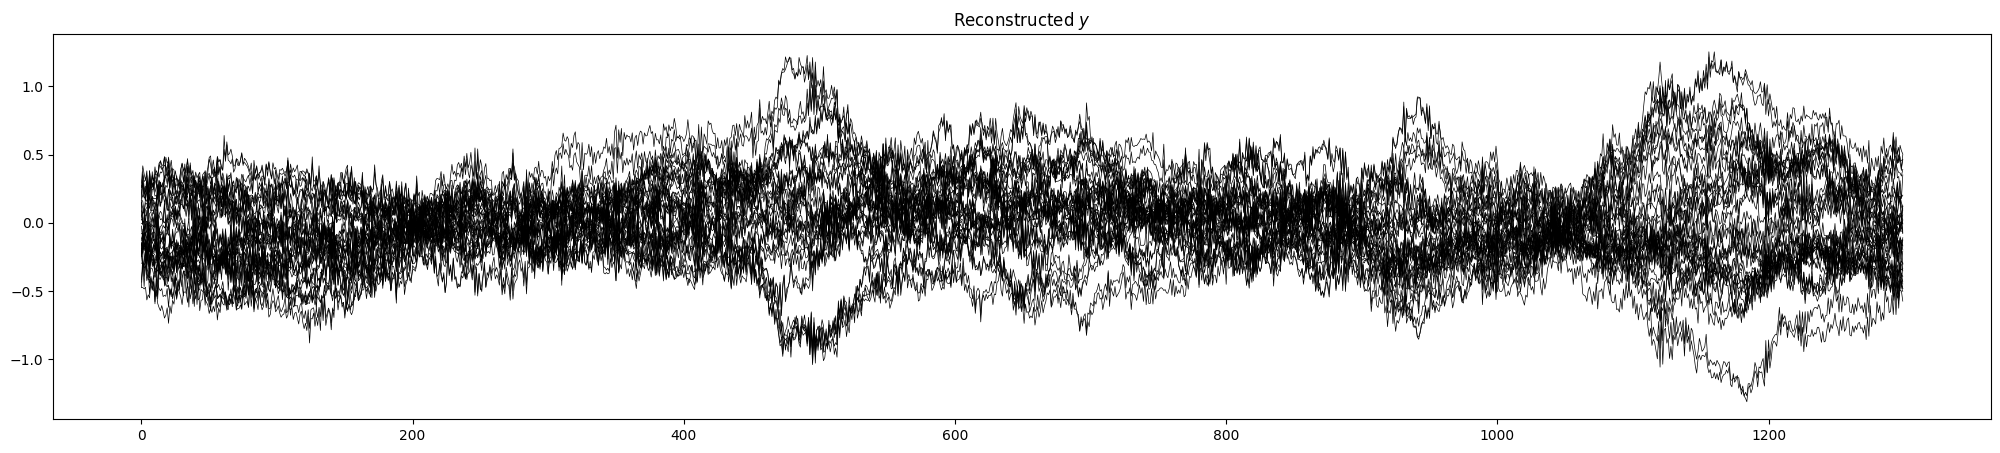

In [ ]:
plot_reconstructed_y(mod, y, c='black', linewidth=0.5)
plt.plot(y, c='black', linewidth=0.5);


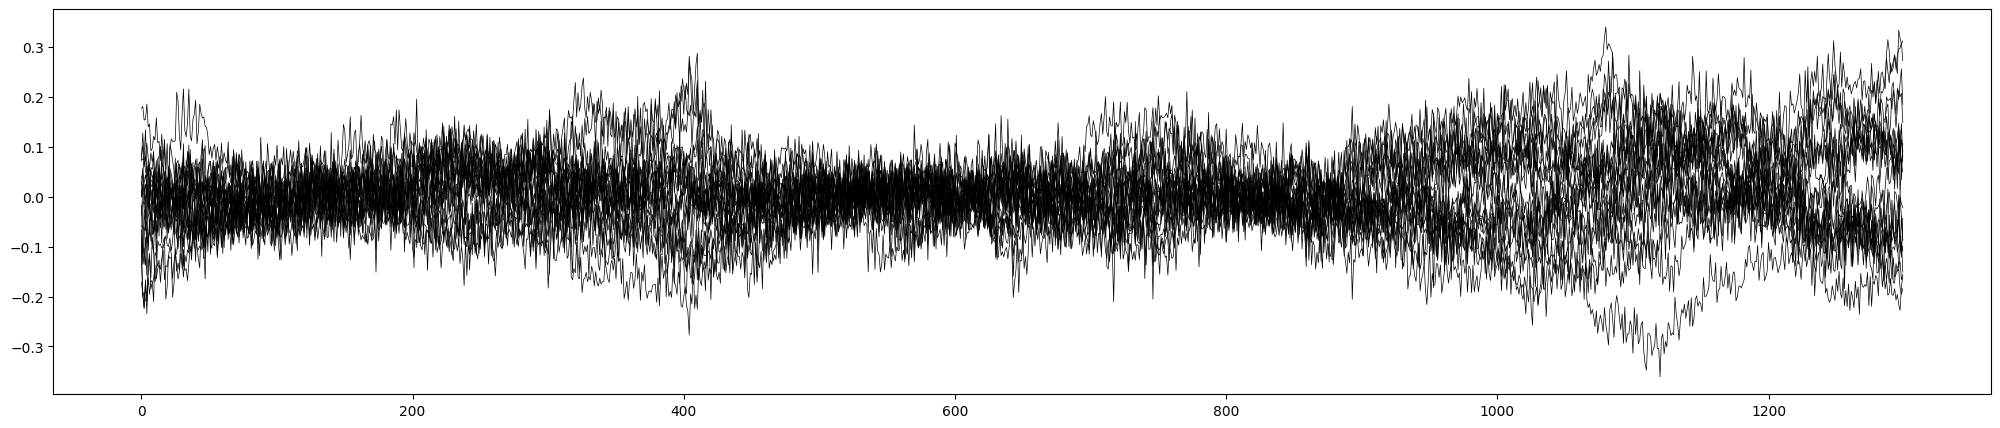

In [ ]:
y_pred = mod(torch.Tensor(y)).detach().numpy()
plt.figure()
plt.plot(y_pred-y, c='black', linewidth=0.5);

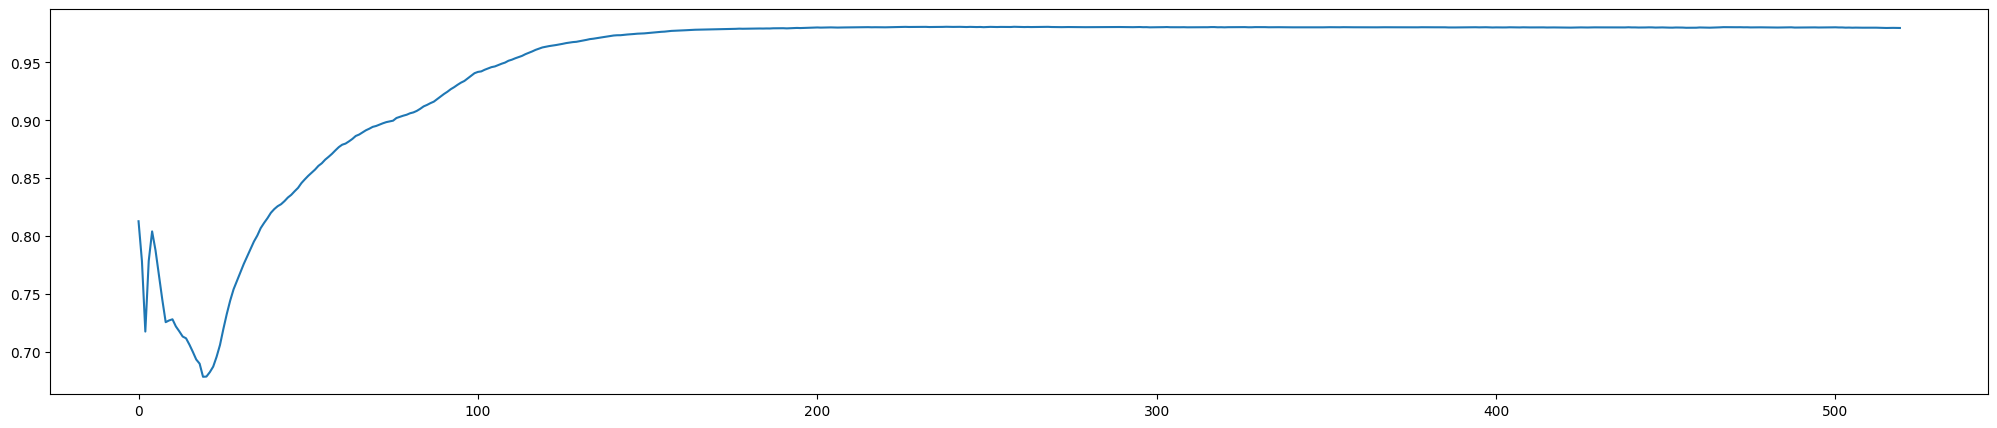

In [ ]:
plt.plot(train_hist['cca_r2'])

In [ ]:
f_test_hat = mod.enc(torch.Tensor(y_test).float()).detach().numpy()
cc = np.mean(CanCorr(f_test_hat, f_test).cancorr)
print(f"cc on test data: {cc}")

cc on test data: 0.9858809254703989


In [ ]:
f_test_hat_rand = np.random.normal(size=(f_test_hat.shape))
cc = np.mean(CanCorr(f_test_hat_rand, f_test).cancorr)
print(f"cc on test data: {cc}")

cc on test data: 0.12512939135027248


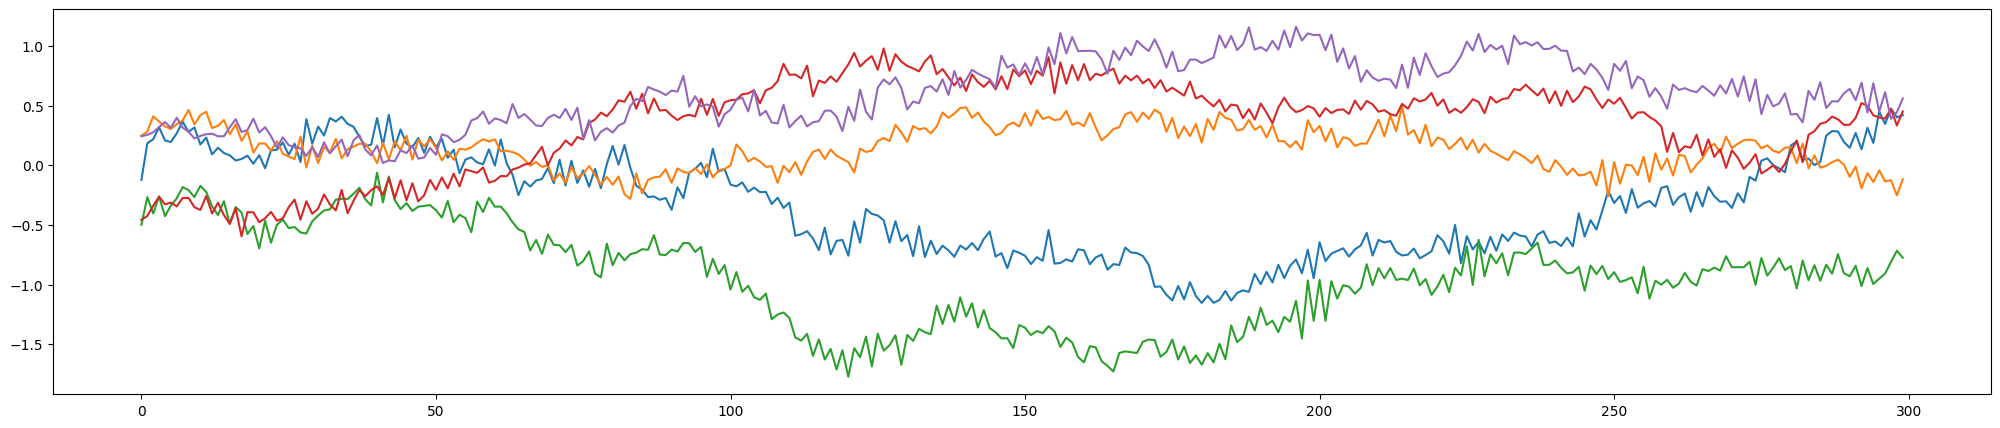

In [ ]:
plt.plot(f_test_hat)